In [75]:
import os
import sys
import glob
import numpy as np
import matplotlib.pyplot as plt

from skimage import io
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import string

In [23]:
image_filename = lambda x: x.split("\\")[-1][:-4]
all_files = glob.glob(pathname = data_folder + "*.png")
list(map(image_filename, all_files))[1]

'22d5n'

In [13]:
data_folder = "./samples/"
len(glob.glob(pathname = data_folder + "*"))

1071

In [66]:
class ImageDataset(Dataset):
    def __init__(self, data_folder_path: str):
        super(Dataset, self).__init__()
        self.files = glob.glob(data_folder_path + "*.png")
        self.targets = list(map(image_filename, self.files))
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx: int):
        image = io.imread(self.files[idx])
        target = self.targets[idx]
        
        return image, target
        

In [71]:
MyDataset = ImageDataset(data_folder)
len(MyDataset)

1040

In [73]:
train_ratio = 0.75
train_size = int(train_ratio * len(MyDataset))
valid_size = len(MyDataset) - train_size
indexes = torch.randperm(len(MyDataset))

train_indexes = indexes[:train_size]
valid_indexes = indexes[train_size:]
assert not set(train_indexes.tolist()).intersection(set(valid_indexes.tolist()))

train_dataset = Subset(MyDataset, train_indexes)
valid_dataset = Subset(MyDataset, valid_indexes)
print(f"{len(train_dataset)=},   {len(valid_dataset)=}")

len(train_dataset)=780,   len(valid_dataset)=260


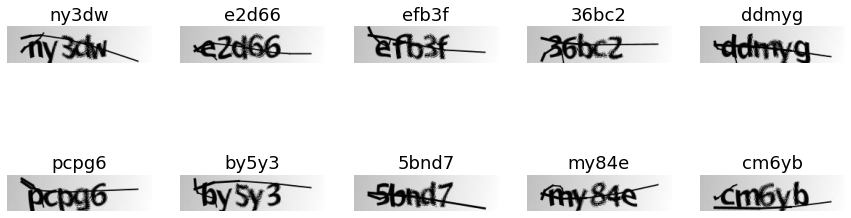

In [74]:
fig = plt.figure(figsize = (15, 5))
for i in range(10):
    sample = train_dataset[i]
    ax = plt.subplot(2, 5, i+1)
    # plt.tight_layout()
    ax.set_title(sample[1], size=18)
    ax.axis("off")
    plt.imshow(sample[0])

In [96]:
target_symbols = list(set(string.ascii_lowercase).union(set(string.digits)))

In [111]:
symbol_to_idx = {symbol: idx+1 for idx, symbol in enumerate(target_symbols)}
idx_to_symbol = {idx+1: symbol for idx, symbol in enumerate(target_symbols)}

# testing
for key, value in symbol_to_idx.items():
    assert idx_to_symbol[value] == key

In [112]:
from typing import List, Tuple

In [113]:
def map_symbol_to_idx(symbols: str):
    return [symbol_to_idx[symbol] for symbol in symbols]

In [150]:
class Collator:
    def __call__(self, batch):
        images_arrays, targets_str = zip(*batch)
        batch_size = len(batch)
        max_len = max(map(len, targets_str))
        targets = torch.zeros(batch_size, max_len, dtype = int)
        for i in range(batch_size):
            targets_i = map_symbol_to_idx(targets_str[i])
            targets[i, :len(targets_str[i])] = torch.as_tensor(targets_i, dtype = int)
        return torch.as_tensor(images_arrays, dtype = torch.float32).permute(0, 3, 1, 2), targets
        

In [151]:
test_sample = [train_dataset[0], train_dataset[1]]
Collator()(test_sample)[1]

tensor([[30, 16, 36, 24,  7],
        [ 3, 28, 24, 11, 11]])

In [152]:
train_dataloder = DataLoader(train_dataset, batch_size=32,
                             shuffle = True, collate_fn = Collator(),
                             drop_last = True)

valid_dataloder = DataLoader(valid_dataset, batch_size=32,
                             shuffle = False, collate_fn = Collator())

In [153]:
next(iter(train_dataloder))[0].shape

torch.Size([32, 4, 50, 200])

### Models Blocks

In [162]:
def conv_3x3(in_channels, out_channels):
    conv = nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), padding = 1)
    batch_norm = nn.BatchNorm2d(out_channels)
    relu = nn.ReLU()
    return nn.Sequential(conv, batch_norm, relu)


In [161]:
conv_3x3(4, 16)(next(iter(train_dataloder))[0]).shape

torch.Size([32, 16, 50, 200])

In [ ]:
class VGG(nn.Module):
    def __init__(self)